# Homework 4
## Part 1: without bundle adjustment

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os
import itertools
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

Import images. I am skipping images 2 and 3, per advice given in class.

In [3]:
imgs = []
dir_name = 'buddha_images/'
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )
# Iterate over sorted list of files and print the file paths 
# one by one.
for file_path in list_of_files:
    imgs.append(cv2.cvtColor(cv2.imread(file_path),cv2.COLOR_BGR2RGB))


Image preprocessing: do image normalization and convert images to grayscale.

In [4]:
# image normalization
def normalizeImgs(imgs):
    normImgs = []
    for img in imgs:
        norm_img = np.zeros(img.shape[:2])
        final_img = cv2.normalize(img,norm_img,0,255,cv2.NORM_MINMAX)
        normImgs.append(final_img)
    return normImgs
    
normImgs = normalizeImgs(imgs)

In [5]:
def convertToGray(normImgs):
    grayImgs = []
    for img in normImgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayImgs.append(gr)
    return grayImgs

grayImgsOrig = convertToGray(normImgs)
image_height, image_width = grayImgsOrig[0].shape

Run the images through CLAHE to improve contrast on the Buddha statue.

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

grayImgs = []
for img in grayImgsOrig:
    img = clahe.apply(img)
    grayImgs.append(img)

Compute the funamental matrix between each image pair. This part originates from the OpenCV tutorial on Epipolar Geometry found [here](https://docs.opencv.org/4.x/da/de9/tutorial_py_epipolar_geometry.html).

First, compute sift keypoints and descriptors. non-maximimum supression is used on the keypoints.

In [7]:
def get_non_max_suppression_mask(keypoints):
    binary_image = np.zeros((image_height, image_width))
    response_list = np.array([keypoint.response for keypoint in keypoints])
    mask = np.flip(np.argsort(response_list))
    point_list = np.rint([keypoint.pt for keypoint in keypoints])[
        mask].astype(int)
    non_max_suppression_mask = []
    for point, index in zip(point_list, mask):
        if binary_image[point[1], point[0]] == 0:
            non_max_suppression_mask.append(index)
            cv2.circle(binary_image, (point[0], point[1]), 2, 255, -1)

    return non_max_suppression_mask

In [8]:
def featureDetector(grayImgs):
    sift = cv2.SIFT_create(nfeatures=4000,nOctaveLayers=12,contrastThreshold=0.025,sigma=1.5)
    #sift = cv2.xfeatures2d.SIFT_create(nfeatures=4000,nOctaveLayers=6,contrastThreshold=0.025,sigma=1.5)

    #sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=6)

    kps = []
    des = []
    outImages = []
    for gr in grayImgs:
        k, d = sift.detectAndCompute(gr,None)
        non_max_suppression_mask = get_non_max_suppression_mask(k) # source: ZZ
        outImage = cv2.drawKeypoints(gr, k, gr,color=[0,255,0],
                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        kps.append(np.array(k)[non_max_suppression_mask])
        des.append(np.array(d)[non_max_suppression_mask])
        outImages.append(outImage)
        
    return kps, des, outImages

In [9]:
kps, des, outImages = featureDetector(grayImgs)

Plot SIFT features

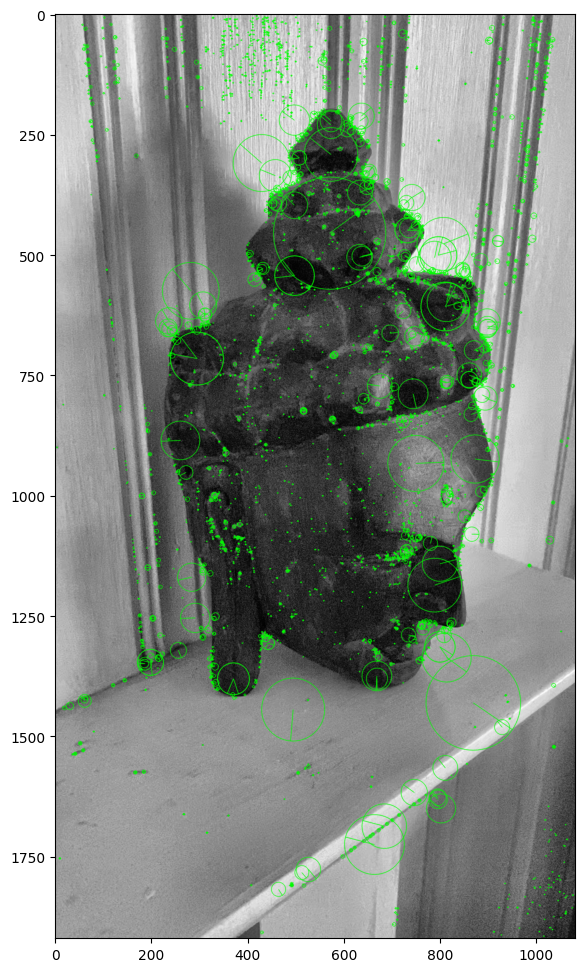

In [10]:
plt.figure(figsize = (12,12))
plt.imshow(outImages[0])

Match images and return match points using a FLANN-based matcher and Lowe's ratio test on the inliers.

In [11]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# do Flann KNN match
flann = cv2.FlannBasedMatcher(index_params,search_params)
def getMatchPoints(kp1, des1, kp2, des2):

    matches = flann.knnMatch(des1,des2,k=2)
    
    # Lowe's ratio test
    pts1 = []
    pts2 = []
    good = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            good.append(m)
            
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return (pts1, pts2), good

Find the fundamental matrix with RANSAC reprojection threshold = 1.0

In [12]:
# camera matrix
#K = np.array([[1, 0, image_width/2],
#              [0, 1, image_height/2],
#              [0, 0, 1]])

K = np.array([[image_width, 0, image_width/2],
            [0, image_width, image_height/2],
            [0, 0, 1]])

In [13]:
def getFundamentalMat(pts1,pts2):
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS,cv2.RANSAC,1.0)
    
    # only select inlier points
    pts1_new = pts1[mask.ravel()==1]
    pts2_new = pts2[mask.ravel()==1]
    return F, mask, (pts1_new, pts2_new)

In [14]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Get matches and find the fundamental matrix for all sequential matches in for loop

In [15]:


ptsList = []
goodMatchList = []
for i in range(len(grayImgs)-1):
    (pts1, pts2), good = getMatchPoints(kps[i],des[i],kps[i+1],des[i+1])
    ptsList.append((pts1, pts2))
    goodMatchList.append(good)


maskList = []
Flist = []
inlier_pts = []
for i in range(len(grayImgs)-1):
    F, mask, (pts1,pts2) = getFundamentalMat(ptsList[i][0],ptsList[i][1])
    Flist.append(F)
    inlier_pts.append((pts1,pts2))
    maskList.append(mask)

In [16]:
len(ptsList)

21

Matches before RANSAC:

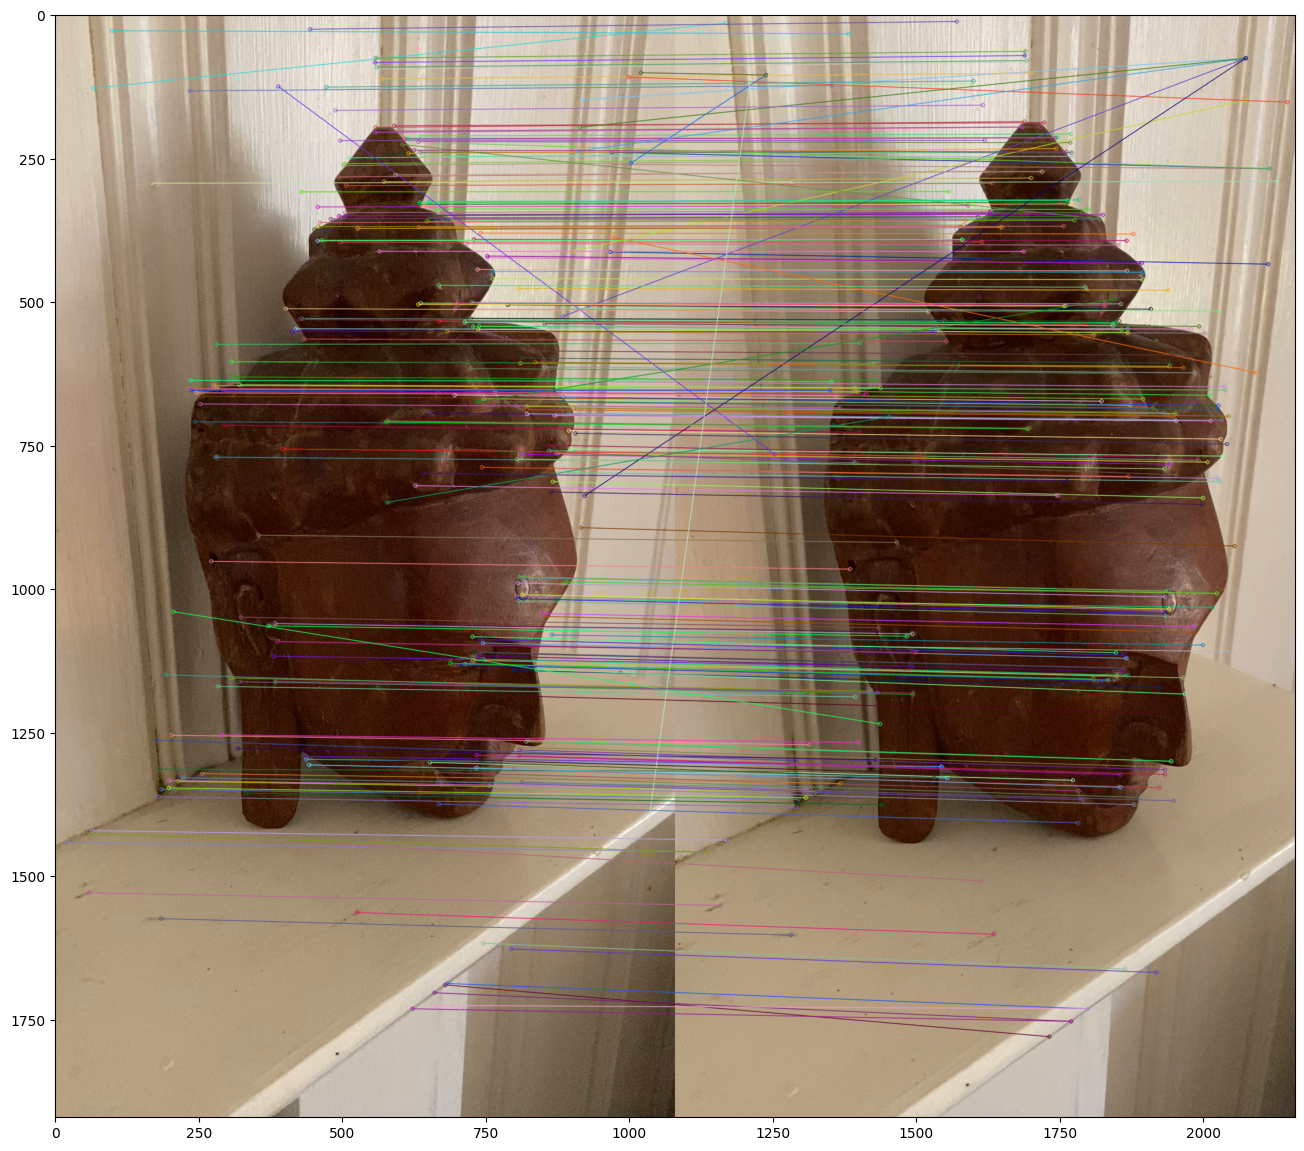

(<matplotlib.image.AxesImage at 0x7fc30a901f10>, None)

In [17]:
img3 = cv2.drawMatches(normImgs[0],kps[0],normImgs[1],kps[1],goodMatchList[0],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (16,16))
plt.imshow(img3),plt.show()

In [18]:
epipolar_imgs = []
for i in range(len(grayImgs)-1):
    # draw epipolar lines
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,Flist[i])
    lines1 = lines1.reshape(-1,3)
    img_left, _ = drawlines(grayImgs[i],grayImgs[i+1],lines1,pts1,pts2)

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,Flist[i])
    lines2 = lines2.reshape(-1,3)
    img_right, _ = drawlines(grayImgs[i+1],grayImgs[i],lines2,pts2,pts1)

    epipolar_imgs.append((img_left,img_right))

Draw epipolar lines for an image pair.

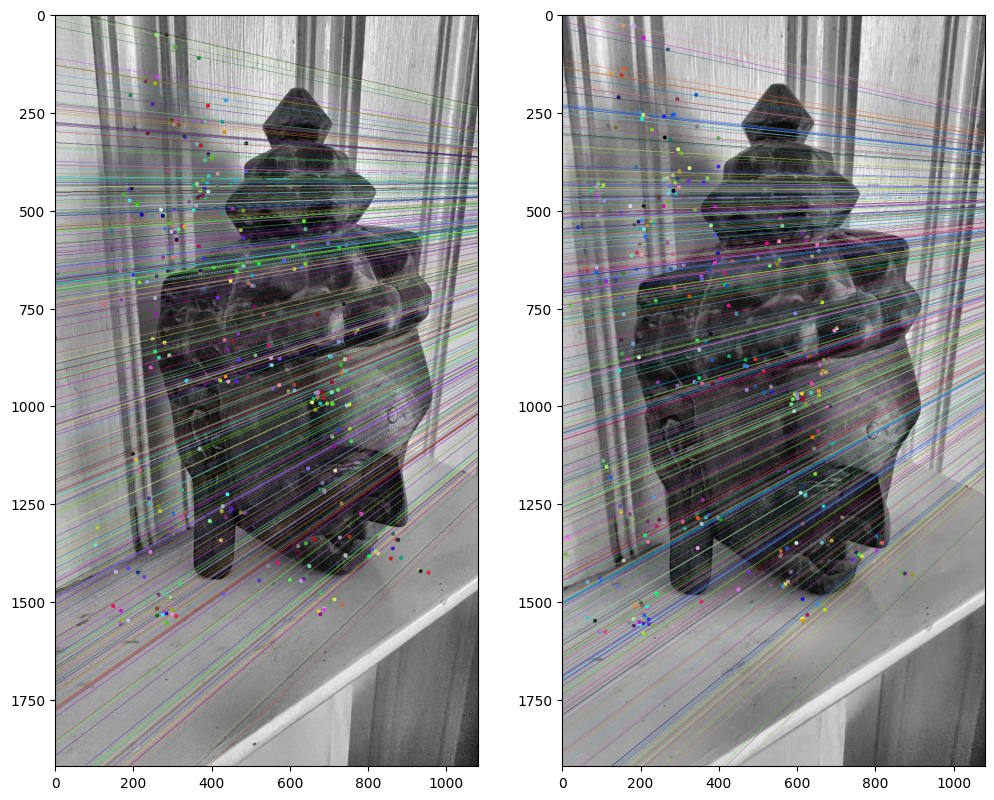

In [19]:
plt.figure(figsize = (12,12))
plt.subplot(121),plt.imshow(epipolar_imgs[1][0])
plt.subplot(122),plt.imshow(epipolar_imgs[1][1])
plt.show()

Refine the 2d point correspondences using correctMatches() in openCV, which minimizes the geometric error using the Optimal Triangulation Method.

In [20]:
def refineMatches(pts1, pts2, F):
    betterPts1, betterPts2 = cv2.correctMatches(F, pts1.reshape(1,-1,2), pts2.reshape(1,-1,2))
    return betterPts1, betterPts2

In [21]:

betterPts = []
for i in range(len(Flist)): 
    betterPts1, betterPts2 = refineMatches(inlier_pts[i][0],inlier_pts[i][1],Flist[i])
    betterPts.append((betterPts1.squeeze(),betterPts2.squeeze()))


Form Essential Matrix. 

In [22]:
 def getEssentialMat(pts1,pts2):
    E, mask = cv2.findEssentialMat(pts1,pts2,K,cv2.RANSAC,prob=0.9,threshold=1.0)
    
    # only select inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return E, mask, (pts1, pts2)

In [23]:
Elist = []
maskList = []
inlier_pts = []
for i in range(len(grayImgs)-1):
    #E, mask, (pts1,pts2) = getEssentialMat(ptsList[i][0],ptsList[i][1])
    E, mask, (pts1,pts2) = getEssentialMat(betterPts[i][0],betterPts[i][1])
    Elist.append(E)
    inlier_pts.append((pts1,pts2))
    maskList.append(mask)

In [24]:
len(inlier_pts[0][0])

128

## Data Association Setup
I am implementing a data association technique used [here](https://github.com/gigakiller/RECONSTRUCT/blob/master/rich_features.py), where 2D and 3D points are defined as classes and we can attach indicies to the 3d point cloud. We can then scan the point cloud to add new ones to the frame. It uses "local polynomial expansion" to align the 3D points with the 2D matches.

In [25]:
class Point3D(object):
    def __init__(self, coords, origin):
        self.coords = coords
        self.origin = origin

class Point2D(object):
    def __init__(self, view, coords):
        self.view = view
        self.coords = coords

In [26]:
def attach_indices(i, pts_3D, src_pts, dst_pts, pt_cloud_indexed=[]):
    '''Attach to each 3D point, indices into the original lists of keypoints and descriptors 
    of the 2D points that contributed to this 3D point in the cloud.'''

    def find_point(new_pt, pt_cloud_indexed):
        for old_pt in pt_cloud_indexed:
            try:
                if np.array_equal(new_pt.origin[i], old_pt.origin[i]):
                    return True, old_pt
            except KeyError:
                continue
        return False, None

    new_pts = [ Point3D(pt, {i: src_pts[num], i+1: dst_pts[num]}) for num, pt in enumerate(pts_3D) ]

    if pt_cloud_indexed == []:
        pt_cloud_indexed = new_pts
    else:
        for num, new_pt in enumerate(new_pts):
            found, old_pt = find_point(new_pt, pt_cloud_indexed)
            if found:
                old_pt.origin[i+1] = dst_pts[num]
            else:
                pt_cloud_indexed.append(new_pt)

    return pt_cloud_indexed

In [27]:
def scan_cloud(i, prev_dst, src_pts, pt_cloud_indexed):
    '''Check for matches between the new frame and the current point cloud.'''
    # prev_dst contains the x & y coords of the keypoints from the second image in the last iteration
    # src_pts contains the x & y coords of the keypoints from the first image in the current iteration
    # the second image in the last iteration is the first image in the current iteration
    # therefore, check for matches by comparing the x & y coords
    matched_pts_2D = []
    matched_pts_3D = []
    indices = []

    for idx, new_pt in enumerate(src_pts):
        for old_pt in prev_dst:
            if np.array_equal(new_pt, old_pt):
                # found a match: a keypoint that contributed to both the last and current point clouds
                matched_pts_2D.append(new_pt)
                indices.append(idx)

    for pt_2D in matched_pts_2D:
        # pt_cloud_indexed is a list of 3D points from the previous cloud with their 2D pixel origins
        for pt in pt_cloud_indexed:
            try:
                if np.array_equal(pt.origin[i], pt_2D):
                    matched_pts_3D.append( pt.coords )
                    break
            except KeyError:
                continue
        continue

    matched_pts_2D = np.array(matched_pts_2D, dtype='float32')
    matched_pts_3D = np.array(matched_pts_3D, dtype='float32')

    return matched_pts_2D, matched_pts_3D, indices

## End data association, start recover pose.

Recover pose from the essential matrix by using cv2.recoverPose

In [28]:
def getPose(E, E_mask, ptsList):
    #essential_mask = np.squeeze(E_mask != 0) # from ZZ
    index_mask = np.arange(len(ptsList[1]))

    #index_mask = index_mask[essential_mask]
    #dst_points = ptsList[0][essential_mask]
    #src_points = ptsList[1][essential_mask]

    _, rotation_matrix, translation, pose_mask, triang_pts = cv2.recoverPose(E, ptsList[0], ptsList[1], K, distanceThresh=25)

    pose_mask = np.squeeze(pose_mask != 0)
    triang_pts_norm = (triang_pts/triang_pts[-1])[:-1].T # normalized 3D points (non-homogeneous 3d points)
    
    
    # apply cheirality check to points
    pts1 = ptsList[0][pose_mask]
    pts2 = ptsList[1][pose_mask]
    
    return rotation_matrix, translation, (pts1, pts2), triang_pts_norm

In [29]:
# used to combine rotation and translation matrix
# source: ZZ
def getTransformationMat(rotation_matrix, translation):
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :] = np.hstack((rotation_matrix, translation))
    return transformation_matrix

The wonderful thing about cv2.recoverPose is that it also returns triangulated 3D points that pass the Cheirality check. In the loop below, I also find and apply a scale factor that scales between the previous 3D points and the current 3D points, from which I can apply to my translation.

In [30]:
poseList = []
#poseMaskList = []
infront_pts = []
pts_3dList = []

#print(inlier_pts[0][1])

# append a prior pose for first image (pose at origin, (0,0,0))
poseList.append(getTransformationMat(np.eye(3),np.array([[0],[0],[0]])))

for i in range(len(grayImgs)-1):
    rotation_matrix, translation, pt_tuple, triang_pts = getPose(Elist[i],maskList[i],inlier_pts[i])
    #print(translation)
    # scale here
    if i != 0:
        
        scale = 0
        for prevPt, pt in zip(pts_3dList[i-1], triang_pts):
            # norm of previous / current points
            scale += cv2.norm(pt) /cv2.norm(prevPt)
        scale /= len(triang_pts)
        print(scale)
        translation *= scale
        poseList.append(getTransformationMat(rotation_matrix,translation).dot(prevTransformation))
        #poseList.append(getTransformationMat(rotation_matrix,translation))
        
    else:
        poseList.append(getTransformationMat(rotation_matrix,translation))
        
    infront_pts.append(pt_tuple)
    pts_3dList.append(triang_pts)
    prevTransformation = getTransformationMat(rotation_matrix,translation)
    #poseMaskList.append(pose_mask)

0.45159580528814824
1.0405784643567668
1.6839846766122195
1.1167200355997202
0.4009950495627438
1.001286193741896
1.3755377943905487
0.7963039607537251
1.0079122069882596
0.9475653993272363
0.4004174928515633
1.0818794458127854
1.5362387251844736
0.930140912869182
0.6130875573806596
0.771863857516213
1.661993568748684
0.9101219153084968
1.3051148163950863
0.7019409811107802


Apply data association from earlier to organize the 3D points.

In [31]:
# use data association on the pointcloud
# might need to use infront_pts instead of inlier_pts
pt_cloud_indexed = []
# changed from pts_3dList - 1 to pts_3dList
for i in range(len(pts_3dList)):
    if pt_cloud_indexed == []:
        pt_cloud_indexed = attach_indices(i, pts_3dList[i], inlier_pts[i][0], inlier_pts[i][1])
    else:
        pt_cloud_indexed = attach_indices(i, pts_3dList[i], inlier_pts[i][0], inlier_pts[i][1],pt_cloud_indexed)

In [32]:
len(pt_cloud_indexed)

3864

In [33]:
# recover the matched 2d and matched 3d points from the pointcloud by using scan_cloud
# but why even need to recover?
# even with edits...I don't think the scan_cloud will serve my purpose
# indices is only the point indices of the dst_img, not source
matched_pts_2D_list = []
matched_pts_3D_list = []
indices_list = []
for i in range(len(pts_3dList)-1):
    if i > 0:
        matched_pts_2D, matched_pts_3D, indices = scan_cloud(i, inlier_pts[i-1][1], inlier_pts[i][0], pt_cloud_indexed)
        matched_pts_3D_list.append(matched_pts_3D)
        indices_list.append(indices)
    
        matched_pts_2D_list.append(matched_pts_2D)
    

In [34]:
indices_list[0]

[10, 12, 16, 24, 27, 33, 44, 49, 53, 58, 68, 91]

In [35]:
pt_cloud_indexed[50].origin

{0: array([889, 987], dtype=int32), 1: array([ 944, 1009], dtype=int32)}

In [36]:
pt_cloud_indexed[50].coords

array([ 8.84696815,  0.69103505, 27.34080967])

### Start putting poses into GTSAM
Initializing GTSAM with noise, similar to ZZ and SFM Example documentation found [here](https://github.com/borglab/gtsam/blob/develop/python/gtsam/examples/SFMExample.py).

In [37]:
import gtsam
from gtsam import symbol_shorthand

from gtsam import (Cal3_S2, DoglegOptimizer,
                         GenericProjectionFactorCal3_S2, Marginals,
                         NonlinearFactorGraph, PinholeCameraCal3_S2, Point3,
                         Pose3, PriorFactorPoint3, PriorFactorPose3, Rot3, Values)
from gtsam.utils import plot

# L is the integer key for landmarks
L = symbol_shorthand.L

# X is the integer key for poses
X = symbol_shorthand.X

In [38]:
# initialize camera matrix
gtsam_camera_matrix = gtsam.Cal3_S2(
    K[0, 0], K[1, 1], 0.0, K[0, 2], K[1, 2])

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)
#measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 0.5)

# initialize pose noise
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

#pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
#    np.array([0.1, 0.1, 0.1, 0.02, 0.02, 0.02]))

# noise for 3D points because of scale ambiguity
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

graph = gtsam.NonlinearFactorGraph()

initial = gtsam.Values()

Add priors the gtsam factor graph

In [39]:
# this function is from ZZ's code. 
# It does the math to convert from the transformation matrix to the projection matrix.
def get_projection_matrix(transformation_matrix):
    return K.dot(np.linalg.inv(transformation_matrix)[:3])
#     return camera_matrix.dot(transformation_matrix[:3])

In [40]:
pose_factor = gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), pose_noise)
graph.push_back(pose_factor)

Get projection matrices for each transformation matrix.

In [75]:
poseList[1]

array([[ 0.99807668, -0.02273219,  0.0576731 , -0.60375767],
       [ 0.0232822 ,  0.99968947, -0.0088827 ,  0.52669837],
       [-0.05745327,  0.01020837,  0.998296  , -0.59838575],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [41]:
proj_matList = []
for transformation in poseList:
    projection_matrix = get_projection_matrix(transformation)
    proj_matList.append(projection_matrix)


Start adding a prior on the position of the first landmark. This fixes the scale ambiguity of the SFM problem.

In [42]:
point_factor = gtsam.PriorFactorPoint3(L(0), pt_cloud_indexed[0].coords, point_noise)
graph.push_back(point_factor)

In [43]:
pt_cloud_indexed[0].coords

array([ 7.65659552, -3.72581205, 23.86554156])

In [67]:
len(pt_cloud_indexed[0])

TypeError: object of type 'Point3D' has no len()

Convert 3D points to GTSAM Point3 objects.

In [44]:
# creates list of 3d points for a given pose/position
def createGtsamPointList(pts_3d):
    pointList = []
    for pt in pts_3d:
        gtsam.Point3(pt[0],pt[1],pt[2])
        pointList.append(pt)
    
    return pointList

def createGtsamPoint(pt_3d):
    return gtsam.Point3(pt_3d[0],pt_3d[1],pt_3d[2])

createGtsamPoint(pt_cloud_indexed[3].coords)

array([ 2.97016732, -5.47516698, 12.95244302])

In [45]:
list(pt_cloud_indexed[3].origin.keys())

[0, 1]

Add simulated camera pose measurements to the factor graph.

In [46]:
# V2 of adding simulatied camera pose with new data association method
for j, pt_cloud_object in enumerate(pt_cloud_indexed):
    point = createGtsamPoint(pt_cloud_object.coords)
    measurements = list(pt_cloud_object.origin.values())
    for i, poseIndex in enumerate(list(pt_cloud_object.origin.keys())):
        p = gtsam.Pose3(gtsam.Rot3(poseList[poseIndex][:3,:3]), gtsam.Point3(poseList[poseIndex][:3,3].flatten()))
        camera = PinholeCameraCal3_S2(p, gtsam_camera_matrix)
        try:
            #measurement = camera.project(point)

            measurement = measurements[i]
            
            factor = GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(poseIndex), L(j), gtsam_camera_matrix)
            graph.push_back(factor)
        except RuntimeError:
            print("cheirality exception caught!")
            continue

In [47]:
#graph.print('Factor Graph:\n')

In [48]:
#print("\nFactor Graph:\n{}".format(graph))  # print

Generate initial estimates. One thing I found interesting about ZZ's code is that he does not assign random noise to the estimates like the gtsam example does. If I omit the random noise, then my initial estimate error is lower, but my final, optimized error remains the same as if I include the random noise. GTSAM must do a good job at filtering out random noise!

In [49]:
# ground truth V2
# gtsam data structure generation for ground truth
#initial_estimate = Values()

for i, pose in enumerate(poseList):
    p = gtsam.Pose3(gtsam.Rot3(pose[:3,:3]), gtsam.Point3(pose[:3,3].flatten()))
    #transformed_pose = p.retract(0.1*np.random.randn(6,1))
    initial.insert(X(i), p)

# check this
# use pose with the most 3d points as the ground truth landmark list
for j, pt_cloud_object in enumerate(pt_cloud_indexed):
    point = createGtsamPoint(pt_cloud_object.coords)
    #transformed_point = point + 0.1*np.random.randn(3)
    initial.insert(L(j), point)


In [50]:
#initial.print('Initial Estimates:\n')

In [51]:
 # Optimize the graph and print results
#params = gtsam.DoglegParams()
params = gtsam.LevenbergMarquardtParams()

params.setVerbosity('TERMINATION')
#params.setDeltaInitial(10.0)
#optimizer = DoglegOptimizer(graph, initial, params)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

print('Optimizing:')
result = optimizer.optimize()
result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial)))
print('final error = {}'.format(graph.error(result)))

Optimizing:
Final results:

Values with 3886 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	6.5785315167;
	-2.38691918171;
	24.3881423242
]
converged
errorThreshold: 21923.8 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 26 >? 100

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.341733979525;
	-12.6358316097;
	18.7681130748
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.050446326;
	-7.66265520122;
	19.1919060359
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.708022243926;
	-3.2684792462;
	6.48527478073
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	3.13490127321;
	-5.61082634233;
	17.7673772447
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.52065358018;
	-13.5527081934;
	20.2559781165
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.15237062507;
	-2.6182432405;
	19.3501967715
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.47413061313;
	-9.23871471444;
	18.9677025227

In [52]:
pt_cloud_indexed[0].origin.values()

dict_values([array([886, 791], dtype=int32), array([944, 807], dtype=int32)])

In [53]:
count = 0

    
print(count)
print(len(pt_cloud_indexed))

0
3864


In [54]:
print('initial error = {}'.format(graph.error(initial)))

initial error = 51982252.88033721


In [55]:
print('final error = {}'.format(graph.error(result)))

final error = 21923.838330643626


In [56]:
#graph.saveGraph('graphV3.dot')

In [57]:
'''
marginals = Marginals(graph, result)
plot.plot_3d_points(1, result, marginals=marginals)
plot.plot_trajectory(1, result, marginals=marginals, scale=8)
plot.set_axes_equal(1)
plt.show()
'''

'\nmarginals = Marginals(graph, result)\nplot.plot_3d_points(1, result, marginals=marginals)\nplot.plot_trajectory(1, result, marginals=marginals, scale=8)\nplot.set_axes_equal(1)\nplt.show()\n'

Get color of each point for plotting

In [58]:
def colorPoints(pt_cloud_final):
    point_color_list = []
    for pt_cloud in pt_cloud_indexed:
        img_index_list = list(pt_cloud.origin.keys())
        coords_2d = list(pt_cloud.origin.values())
        bFinal = 0
        gFinal = 0
        rFinal = 0
        for i, img_index in enumerate(img_index_list):
            #print(coords_2d[i])
            #print(coords)
            # image location is imgs[y,x]
            r,g,b = (imgs[img_index][coords_2d[i][1], coords_2d[i][0]])
            bFinal += b
            gFinal += g
            rFinal += r

        # average color over number of images that it was seen in
        bFinal /= len(img_index_list)
        gFinal /= len(img_index_list)
        rFinal /= len(img_index_list)
        point_color_list.append([rFinal,gFinal,bFinal])
    point_color_list = np.array(point_color_list)
    return point_color_list

In [59]:
pt_cloud_final = [pt_cloud.coords for pt_cloud in pt_cloud_indexed]
point_color_list = colorPoints(pt_cloud_final)

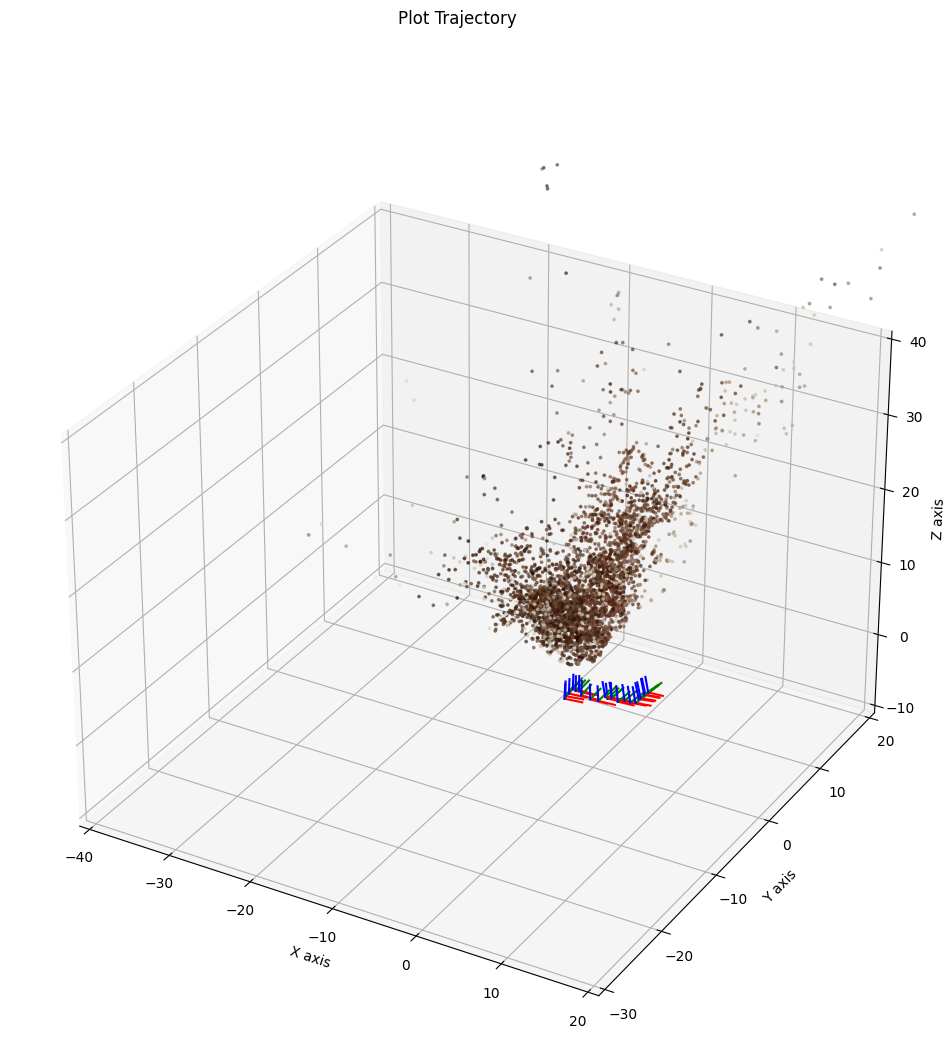

In [62]:
# %matplotlib qt
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=2)
gtsam.utils.plot.set_axes_equal(1)



xPts = [pt_cloud[0] for pt_cloud in pt_cloud_final]
yPts = [pt_cloud[1] for pt_cloud in pt_cloud_final]
zPts = [pt_cloud[2] for pt_cloud in pt_cloud_final]


ax.scatter(xPts, yPts, zPts, s=3, c = point_color_list/255.)
#gtsam.utils.plot.plot_3d_points(1, initial)
#gtsam.utils.plot.plot_3d_points(1, result, linespec = "r*", )


ax.set_xlim3d(-40, 20)
ax.set_ylim3d(-30, 20)
ax.set_zlim3d(-10, 40)


plt.show()

In [ ]:
pt_cloud_final[0]

array([ 9.81970343, -4.81033263, 30.66657637])